<a href="https://colab.research.google.com/github/tomonari-masada/course2022-stats2/blob/main/03_PyMC3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. PyMC3入門 (2)
* 今回、PyMC3を解説するに当たっては、PyMC3の公式サイトを参考にした。
 * https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html

## 3.0 準備

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 1234

rng = np.random.default_rng(SEED)
# https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f

## 3.1 PyMC3によるMCMC

### 3.1.0 MCMC（マルコフ連鎖モンテカルロ）とは
* ベイズ的なモデリングにおいて、事後分布を知ろうとする方法の一つ。
 * もう一つの方法に、変分推論(variational inference)がある。
* MCMCは、事後分布からのサンプルを通して、事後分布そのものを知ろうとする方法。
* モデルが複雑になるほど、事後分布$p(\theta|X)$からのサンプリングは、難しくなっていく。
 * 比較的シンプルなモデルについては、うまいサンプリング手法を構成できる（例：LDAのcollapsed Gibbs sampling）。
* この授業では、MCMCの実際上の使い方を説明する。理屈はあまり説明しない。

### 3.1.1 PyMC3における確率モデルの定義

* PyMC3では、ベイズ的モデルを定義し、観測データを設定すれば、`pm.sample()`を使うことで、事後分布からのサンプルが得られる。

**例題**
 * 数値データがたくさんある。標準偏差は1らしい。平均は0に近いが、0からずれているかもしれない。この平均を知りたい。
 * ベイズ的なモデリングによって、平均がいくらの可能性がどのくらいあるかを表す、事後分布を得ることにする。

* そこで、下記のモデルを使う。
$$ \mu \sim N(0, 1) $$
$$ x \sim N(\mu, 1) $$
 * 事後分布は$p(\mu|X)=\frac{p(X|\mu)p(\mu)}{p(X)}=\frac{p(\mu)\prod_{i=1}^N p(x_i|\mu)}{p(X)}$
* このモデルをPyMC3で書くと、次のようになる。
 * 観測データは正規乱数で人工的に作った。

In [ ]:
observed = rng.standard_normal(100)

In [ ]:
model = pm.Model()

with model:
  mu = pm.Normal("mu", mu=0, sigma=1)
  obs = pm.Normal("obs", mu=mu, sigma=1, observed=observed)

### 3.1.2 PyMC3によるMCMCの実行

* `mu`が従う事後分布$p(\mu|X)$からサンプルを得るには、以下のようにすればよい。
* `tune`は、最初の何個のサンプルを捨てるかを指定する引数。
 * MCMCで得られるサンプルは、最初のほうのものは、通常、捨てる。
* return_inferencedataについては[ここ](https://docs.pymc.io/api/inference.html#pymc3.sampling.sample)を参照。
 * これをTrueにすると、arvizに渡せる形式でサンプリング結果が返ってくる。

In [ ]:
with model:
  trace = pm.sample(2000, tune=3000, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 5 seconds.


* chainとは、サンプルの一つの系列のこと。
* MCMCによるサンプリングでは、直前のサンプルを少し変化させることで、次のサンプルを求める。
 * 前回説明したとおり、この変化のさせ方が賢いので、ちゃんと事後分布からのサンプルになる。
* ということは、サンプルは、初期値から始まって、一筋の系列をなしている。この系列をchainと呼ぶ。
* chainが一つだけだと心もとないので、普通は、複数のchainを走らせる。
* PyMC3のデフォルトの設定では、chainの数は、利用可能なコア数にしたがって自動的に決められる。
* NUTSサンプラーについては後で説明。


**注意** divergenceが0でなかったら、色々と考え直す必要がある。（後の回で説明します。）
 

* 上のコードを実行すると、`trace`にサンプリング結果が保存されている。
* `trace.posterior`によって事後分布の情報にアクセスできる。

In [ ]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    mu       (chain, draw) float64 0.1345 0.1308 0.1305 ... 0.06757 0.06757
Attributes:
    created_at:                 2022-02-21T03:56:49.921962
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              4.738685131072998
    tuning_steps:               3000

### 3.1.3 core数やchain数の指定
* サンプリングに使うcoreの数、生成するchainの数を指定する場合は、以下のようにする。
 * coresがコア数、chainsがchainの数。

In [ ]:
with model:
  trace = pm.sample(2000, tune=3000, cores=4, chains=4, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7153993192280053, but should be close to 0.8. Try to increase the number of tuning steps.


* NUTS(No-U-Turn-Sampler)は、PyMC3においてデフォルトで使われるサンプラー。
* HMCの改良版。詳細は割愛するが、おおよその説明は後ほど。
 * https://mc-stan.org/docs/2_26/reference-manual/hmc-chapter.html
 * https://arxiv.org/abs/1111.4246

* 上の実行例では、chainは4本あり、それぞれ2000のサンプルから成っている。

In [ ]:
trace.posterior["mu"].shape

(4, 2000)

* 特定のchainだけ選ぶ方法は以下の通り。

In [ ]:
trace.posterior["mu"].sel(chain=0).shape

(2000,)

* 特定のchainの、最初の10個のサンプルだけ見てみる。

In [ ]:
trace.posterior["mu"].sel(chain=0)[:10]

<xarray.DataArray 'mu' (draw: 10)>
array([0.12415508, 0.12415508, 0.05033141, 0.10392289, 0.10392289,
       0.08569515, 0.17181741, 0.23408087, 0.23346577, 0.0273854 ])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

* chainの中身のデータ型はxarrayの配列。
 * NumPyの配列とは違う。

In [ ]:
type(trace.posterior["mu"])

xarray.core.dataarray.DataArray

* `.data`でndarrayへ変換できる。

In [ ]:
type(trace.posterior["mu"].data)

numpy.ndarray

In [ ]:
trace.posterior["mu"].data.shape

(4, 2000)

* サンプルのヒストグラムを描くと、事後分布の大体の形が分かる。
* ここでは、あえて、arvizを使わずにヒストグラムを描いてみる。

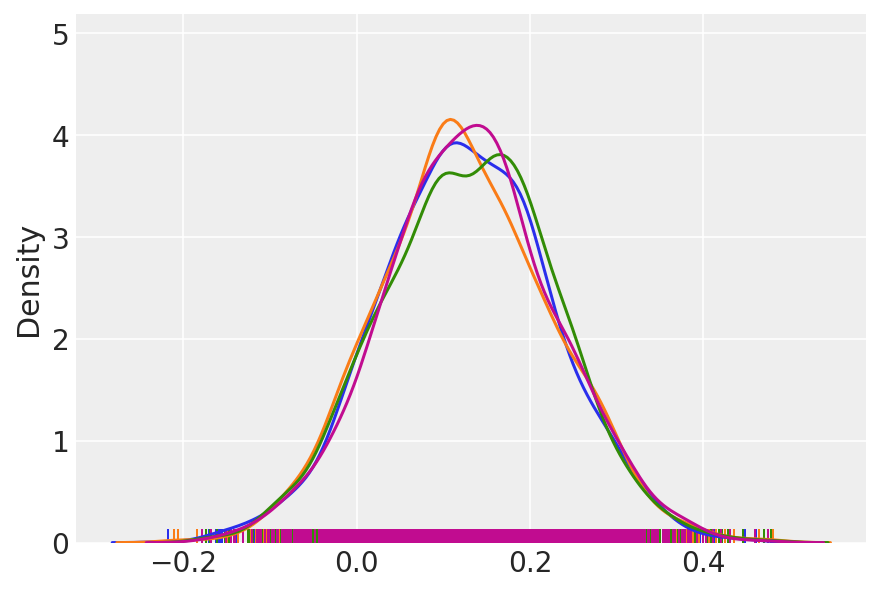

In [ ]:
import seaborn as sns

for i in range(trace.posterior["mu"].data.shape[0]):
  sns.distplot(trace.posterior["mu"].data[i], rug=True, hist=False)

* ピークが0付近に来ていなければ、観測データの平均を確認してみる。

In [ ]:
obs.observations.mean()

0.12730638448504394

* とはいえ、やはり`arviz`を使う方が良い。

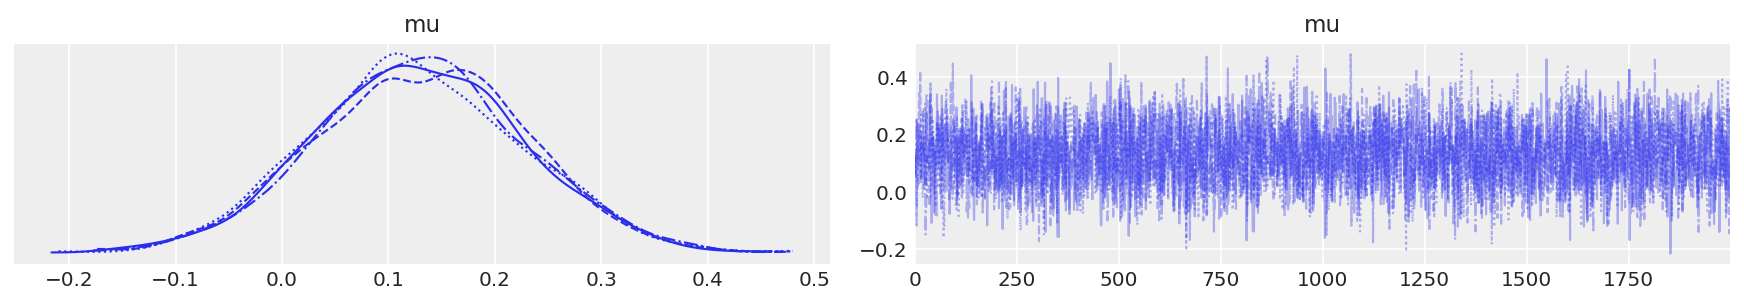

In [ ]:
az.plot_trace(trace);

* さて、chainが４本からなるこのサンプルは、うまく事後分布を表しているのだろうか？
 * 以下、サンプルの分析手法を紹介する。

## 3.2 PyMC3で使えるサンプリング手法

### 3.2.1 どのサンプラーを使うのが良いのか
* https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html には、以下のように書いてある。

> "For almost all continuous models, ``NUTS`` should be preferred."

* ``NUTS``では良いサンプルが得られない場合、``Metropolis``を使う人が多いが、これは良くない選択だ、とも書いてある。
* ``NUTS``でうまくいかない時は、初期値を変えるか、変数変換をするのが良い。
* Metropolis法では、effective sample sizeが小さくなってしまうことが多い。
 * 直前のサンプルがそのまま新しいサンプルとして使われる頻度が相対的に高い。

### 3.2.2 PyMC3で実装されているサンプラーの一覧

In [ ]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']

## 3.3 MCMCの結果の分析
 * https://docs.pymc.io/notebooks/sampler-stats.html
 * https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html 
 * https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

* MCMCを使うときには、得られたchainの良し悪しを気にしないといけない。
* 例えば、chainが事後分布の定義域のごく狭い範囲しか踏査していないかもしれない。


**例題**
* 観測データは正規分布$N(\mu, \sigma^2)$に従うと仮定。
* $\mu$と$\sigma$について事前分布を導入。
$$\begin{align}
\mu & \sim N(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
x & \sim N(\mu, \sigma^2)
\end{align}$$
 * [half-normal分布](https://en.wikipedia.org/wiki/Half-normal_distribution)は、平均0の正規分布に従う確率変数の絶対値が従う分布。
 

### 3.3.1 ヒストグラム


* デフォルトのNUTS以外のサンプラーを試してみる。
* 平均パラメータと標準偏差パラメータとで、サンプリング手法を変えてみる。
 * 平均パラメータはメトロポリス法でサンプリングする。
 * 標準偏差パラメータのサンプリングは[スライスサンプリング](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%A9%E3%82%A4%E3%82%B9%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AA%E3%83%B3%E3%82%B0)で実現する。

In [ ]:
with pm.Model() as model:
  mu = pm.Normal("mu", mu=0, sigma=1)
  sd = pm.HalfNormal("sd", sigma=1)
  obs = pm.Normal("obs", mu=mu, sigma=sd, observed=observed)

In [ ]:
with model:
  step1 = pm.Metropolis(vars=[mu])
  step2 = pm.Slice(vars=[sd])
  trace = pm.sample(10000, step=[step1, step2], return_inferencedata=True, random_seed=SEED)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


* arvizでサンプルを可視化する。
 * デフォルトではkernel density estimates。ヒストグラムも選べる。
 * 全サンプルのプロットも右半分に描かれる。

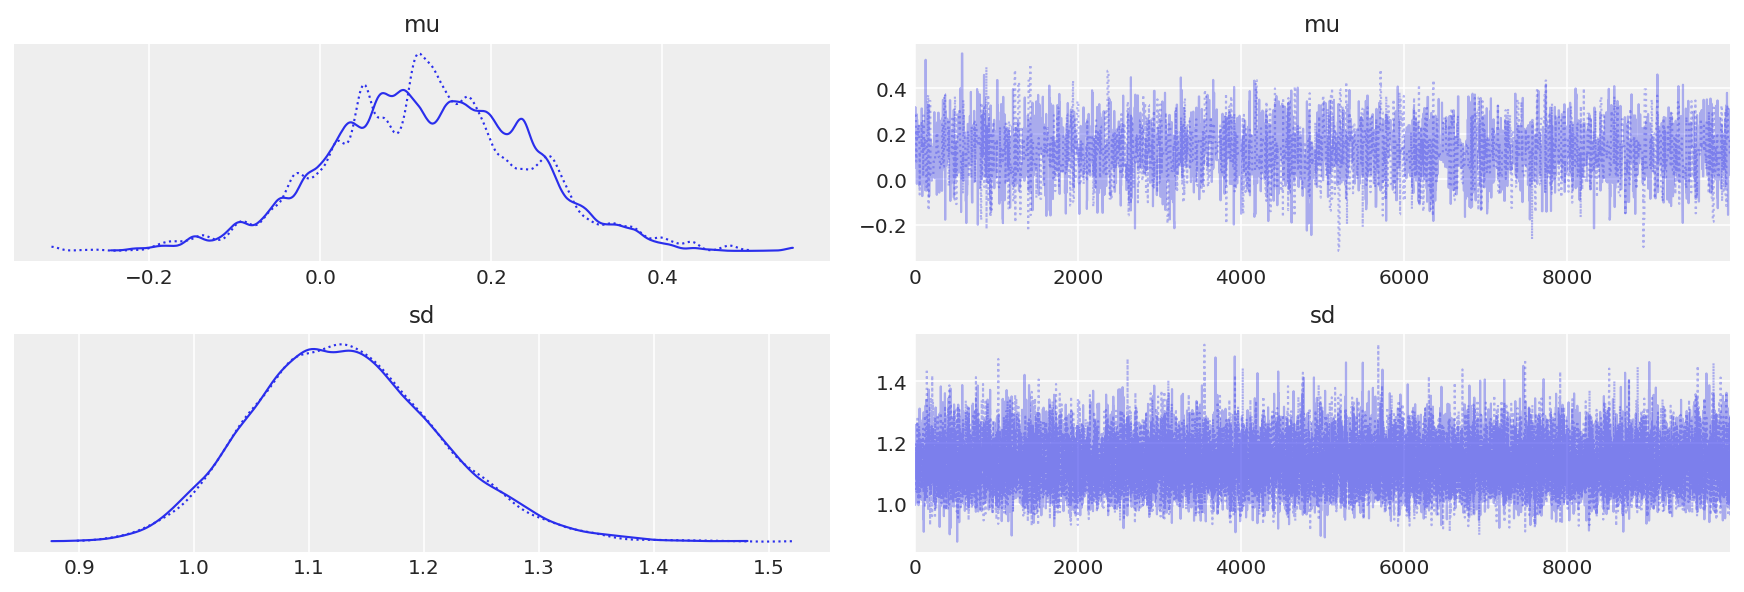

In [ ]:
az.plot_trace(trace);

 * muの分布のほうだけ、densityがやや凸凹しているし、サンプルのプロットも少し様子が違う。

In [ ]:
obs.observations.mean()

0.12730638448504394

In [ ]:
obs.observations.std()

1.1204522311616265

* pair plotで2変数の分布を同時に見る。
 * 周辺分布も表示させることができる。

$$\begin{align}
p(\mu, \sigma | X) & \propto p(X | \mu, \sigma) p(\mu) p(\sigma) & {（事後分布）} \\
p(\mu | X) & = \int p(\mu, \sigma | X) d\sigma & \mbox{（$\mu$の周辺事後分布）} \\
p(\sigma | X) & = \int p(\mu, \sigma | X) d\mu & \mbox{（$\sigma$の周辺事後分布）}
\end{align}$$

/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:234: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


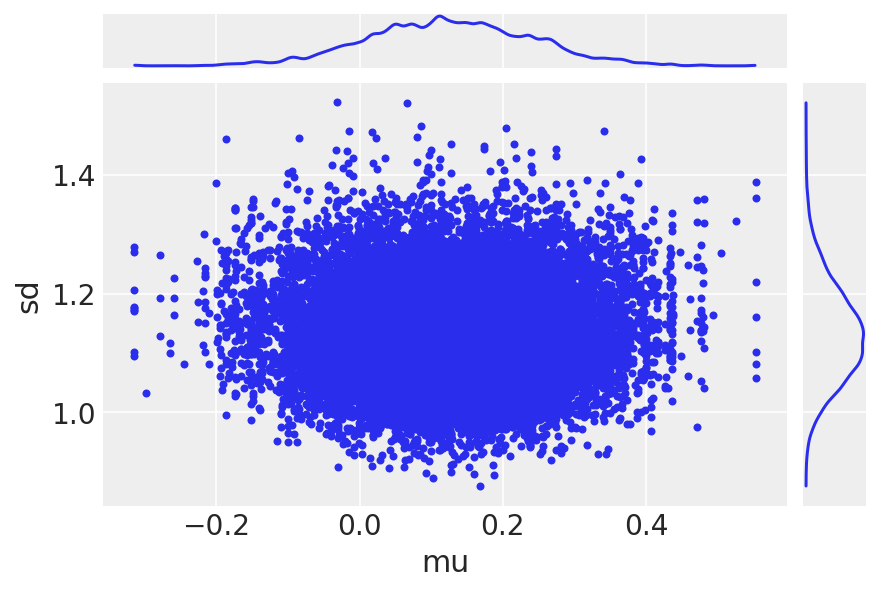

In [ ]:
az.plot_pair(trace, marginals=True, divergences=True);

### 3.3.2 自己相関
* 自己相関は小さいほど良い。
 * 小さいほど、サンプルが相互に独立だとみなせる。
* 比較的大きなラグ(lag)でも相関が0に近くない場合は、問題あり。
* 参考資料
 * https://www.statlect.com/fundamentals-of-statistics/autocorrelation


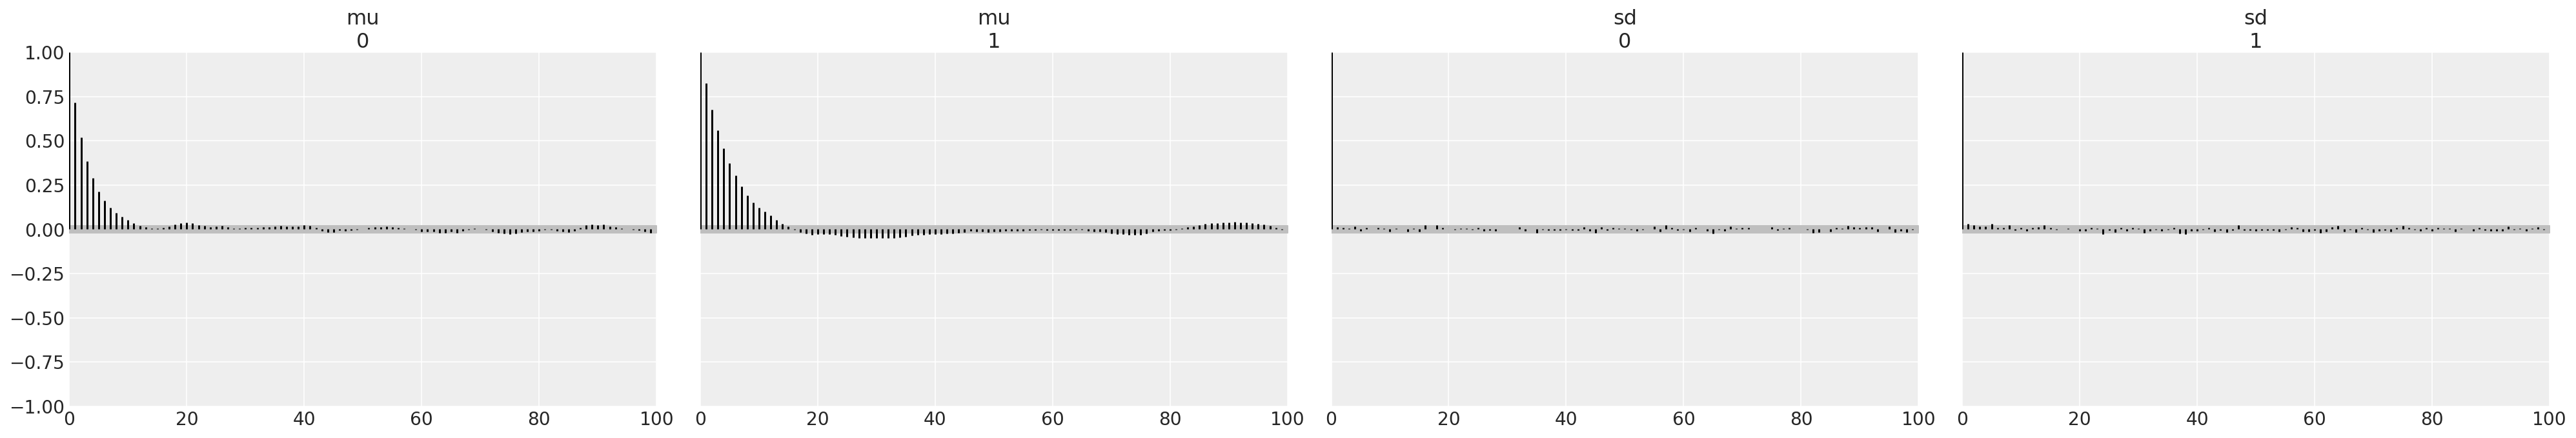

In [ ]:
az.plot_autocorr(trace, var_names=["mu", "sd"]);

* 横軸がラグ。
* muについては、かなり大きなlagについても自己相関が高くなってしまっている。

### 3.3.3 Gelman-Rubin統計量
* 定量的にサンプルの良し悪しを分析できる。
* R-hatと呼ばれる値が1に近いほど、連鎖の分布がより収束している。
 * https://mc-stan.org/docs/2_29/reference-manual/analysis.html を参照。
 * http://www.omori.e.u-tokyo.ac.jp/MCMC/mcmc.pdf の6.2.2を参照。
* R-hatは1.05より小さいことが望ましいらしい。
 * https://www.youtube.com/watch?v=WbNmcvxRwow

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.125,0.115,-0.101,0.335,0.002,0.002,2517.0,2529.0,1.0
sd,1.132,0.080,0.990,1.288,0.001,0.000,17044.0,14955.0,1.0


* mcse, essについては、下記を参照。
 * https://mc-stan.org/docs/2_26/reference-manual/effective-sample-size-section.html

* R-hatは1.0で問題ないように見える。
* だが、muのほうのESS (effective sample size)が小さい。これは問題。

 ### 3.3.4 HDI (highest density interval)
* HDIが何であるかについては下記を参照。
 * http://web.sfc.keio.ac.jp/~maunz/BS14/BS14-11.pdf
 * https://www.sciencedirect.com/topics/mathematics/highest-density-interval 
* arvizのforest plot
  * デフォルトではHDI=94.0%の区間を図示する。
  * r_hat=TrueでR-hat統計量も図示する。

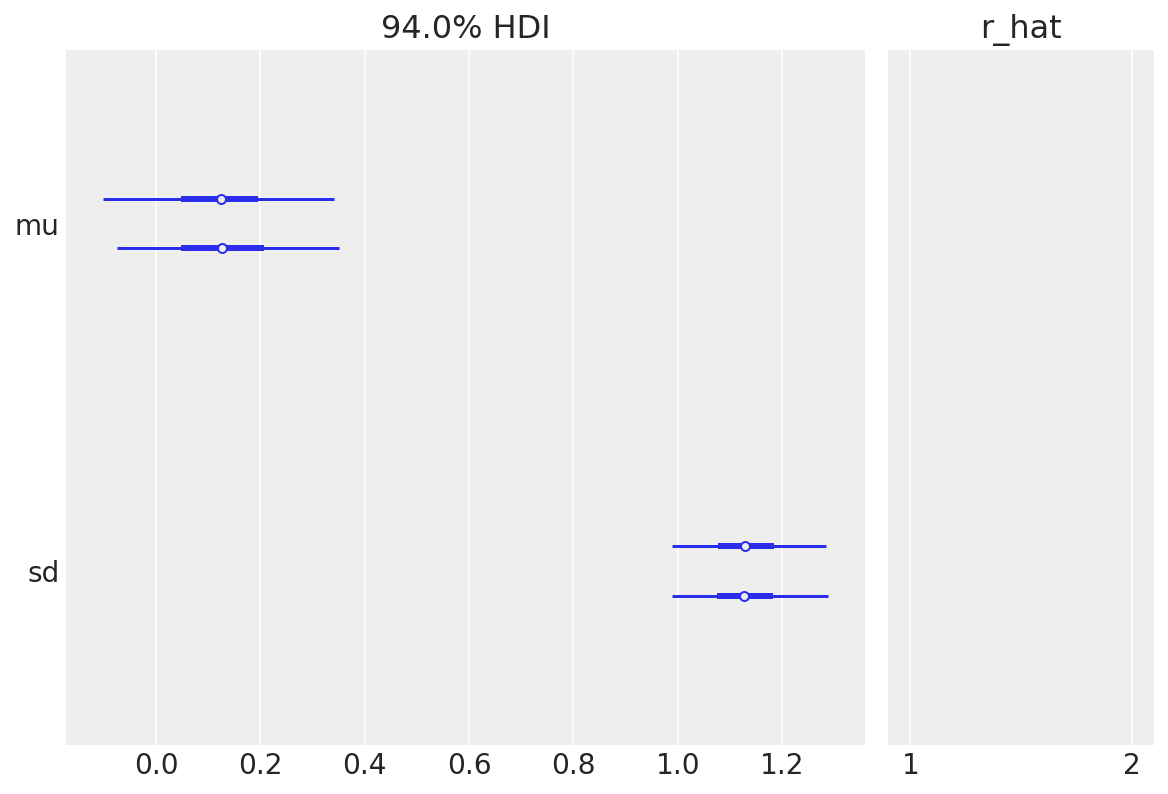

In [ ]:
az.plot_forest(trace, r_hat=True);

* ridge plot

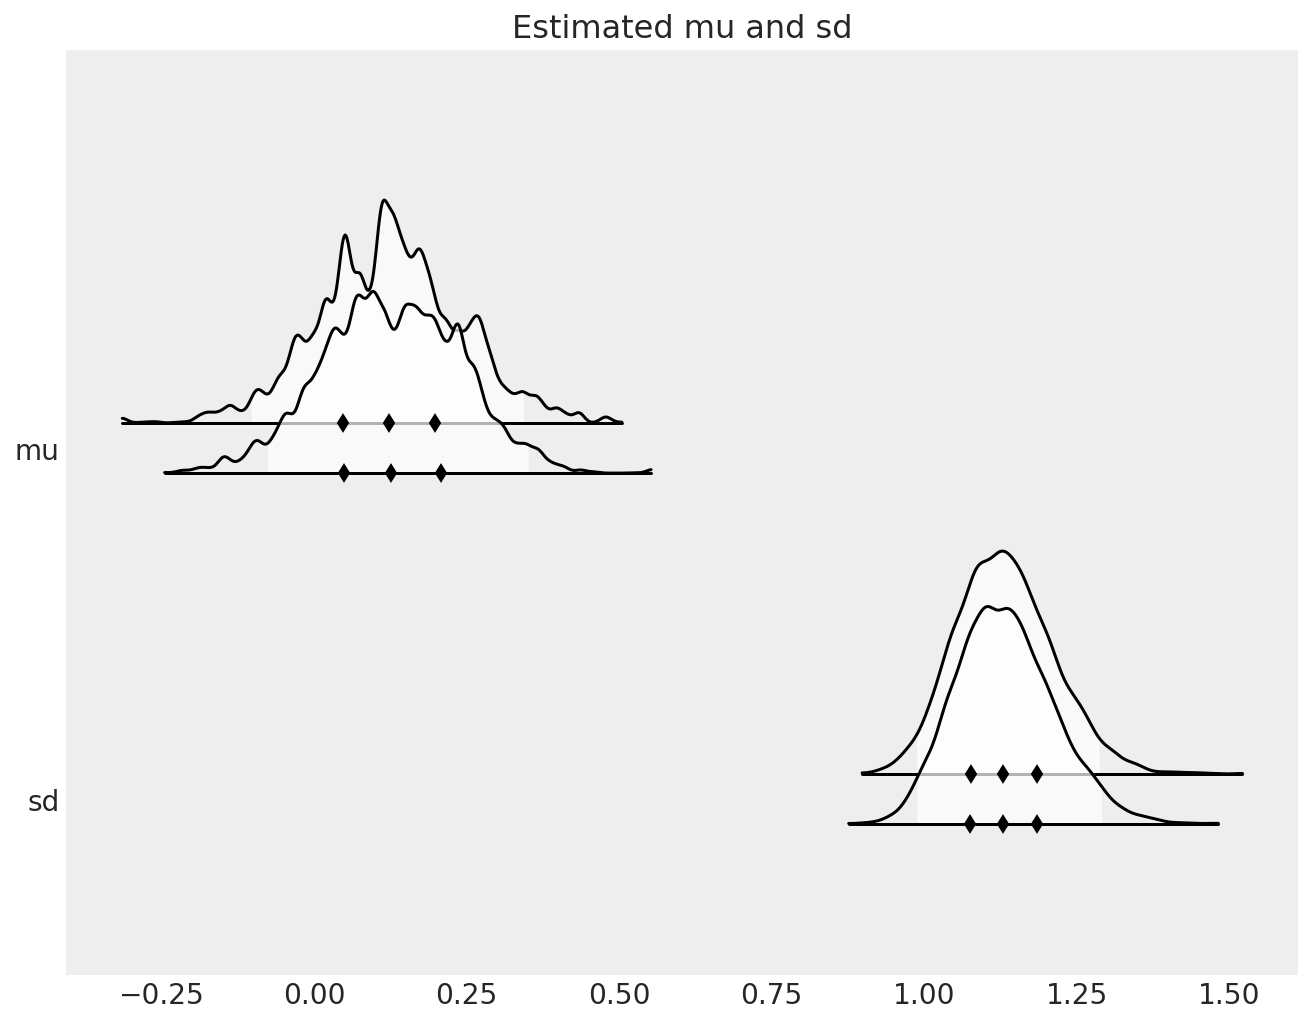

In [ ]:
axes = az.plot_forest(trace,
                      kind='ridgeplot',
                      ridgeplot_truncate=False,
                      ridgeplot_quantiles=[.25, .5, .75],
                      ridgeplot_alpha=.7,
                      colors='white',
                      figsize=(9, 7))
axes[0].set_title('Estimated mu and sd');

* 似ているが別の可視化。
 * https://sites.google.com/site/doingbayesiandataanalysis/ この本の流儀による可視化だそうです（がよく知りません・・・）。
 * これが分かりやすいかもしれません。

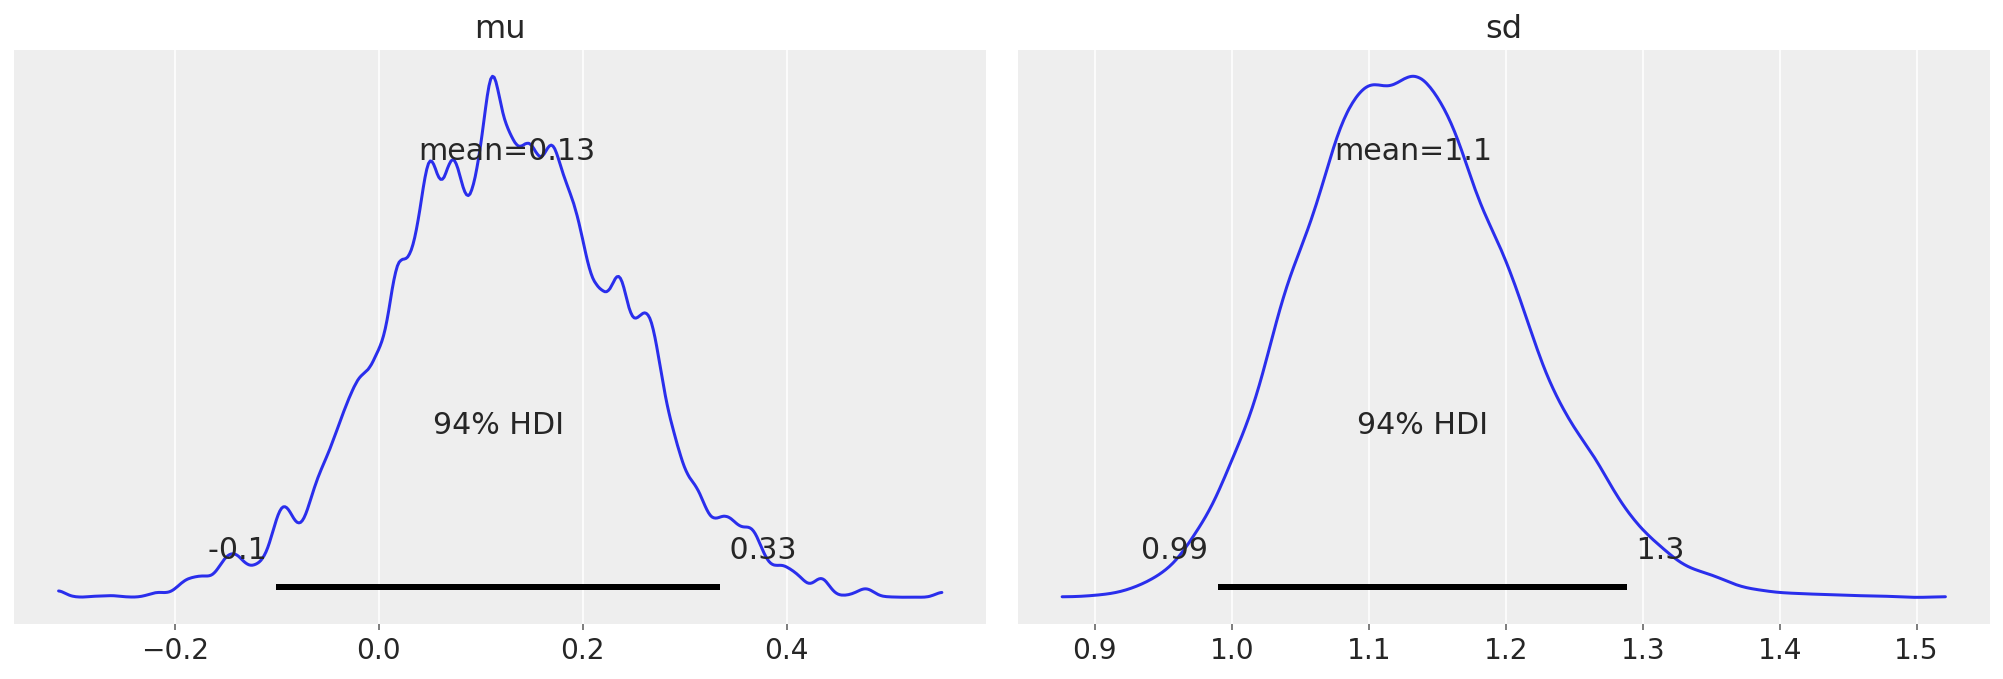

In [ ]:
az.plot_posterior(trace);

### 3.3.5 energy transition distributionとmarginal energy distributionによる分析

* 同じモデルで、二つのパラメータとも、デフォルトのNo-U-Turn Sampler (NUTS)を使う。

In [ ]:
with model:
  trace = pm.sample(10000, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.


* やはり、NUTSのほうが良さそう。

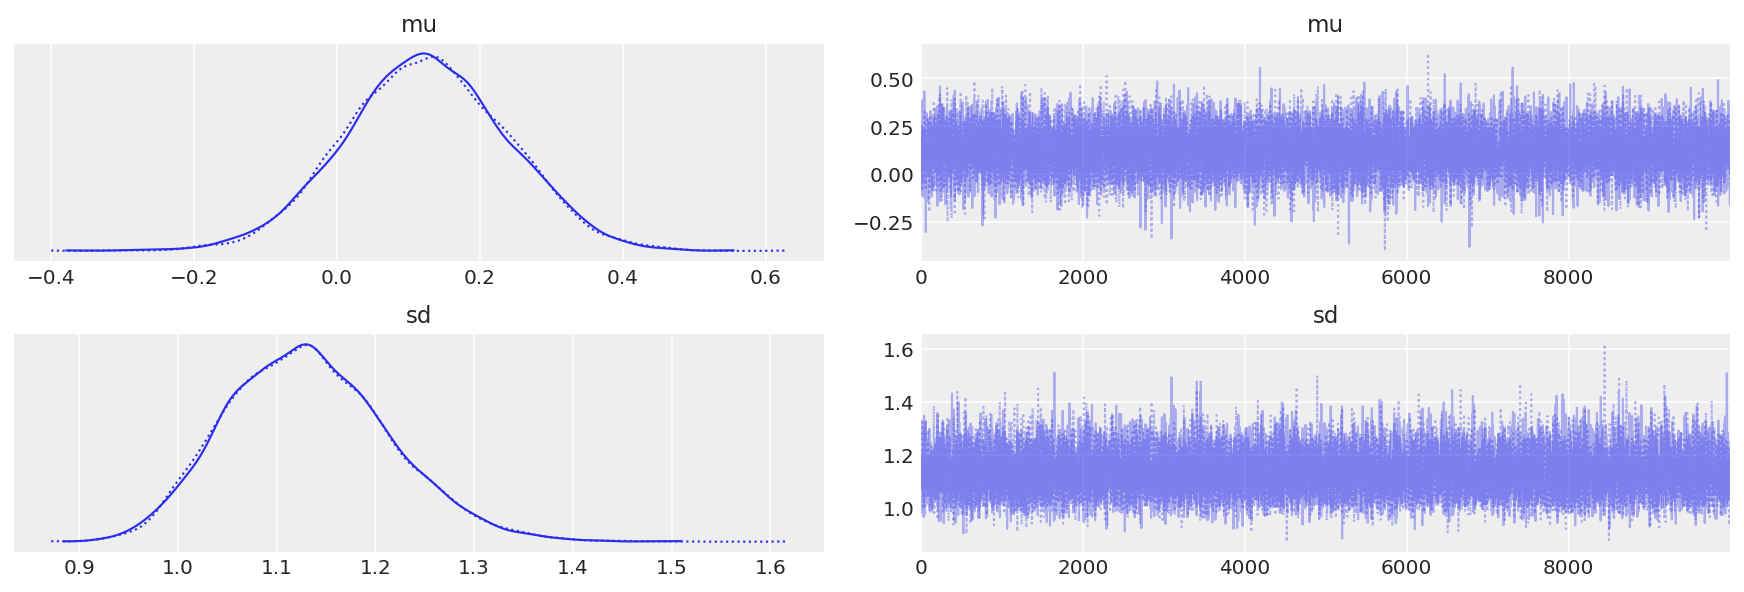

In [ ]:
az.plot_trace(trace);

In [ ]:
obs.observations.mean()

0.12730638448504394

In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.124,0.114,-0.083,0.338,0.001,0.001,17945.0,13639.0,1.0
sd,1.132,0.082,0.984,1.286,0.001,0.000,16932.0,13632.0,1.0


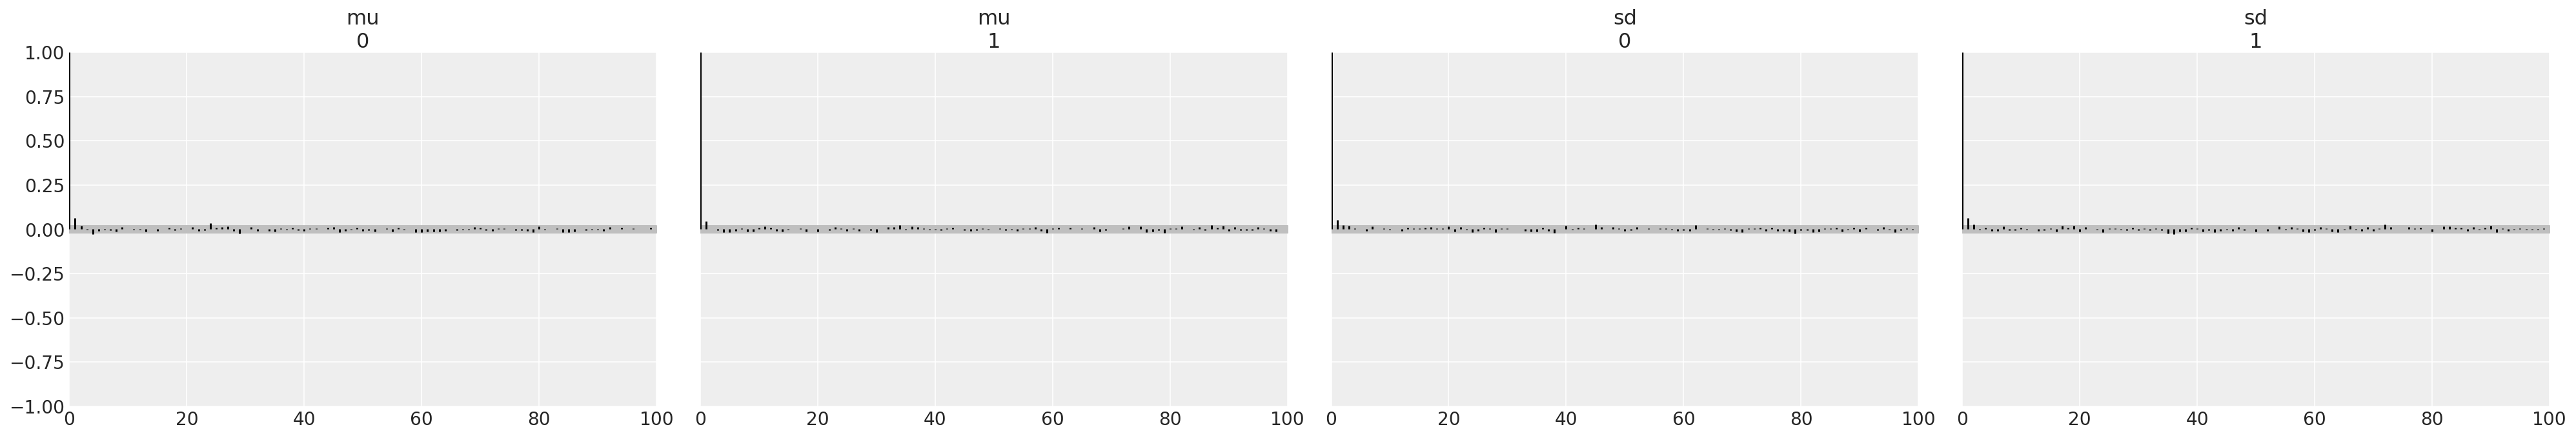

In [ ]:
az.plot_autocorr(trace, var_names=["mu", "sd"]);

* 事後分布がheavy tailedな分布だった場合、chainがその重たい裾野を十分に踏査していない可能性がある。
* arvizのplot_energyで、"Energy transition"の分布の幅のほうが、"Marginal Energy"の分布のそれより、相当狭い場合が要注意！
 * BFMI (Bayesian
fraction of missing information)については https://arxiv.org/abs/1604.00695 の3.1を参照。
 * https://arxiv.org/abs/1701.02434 も参照。

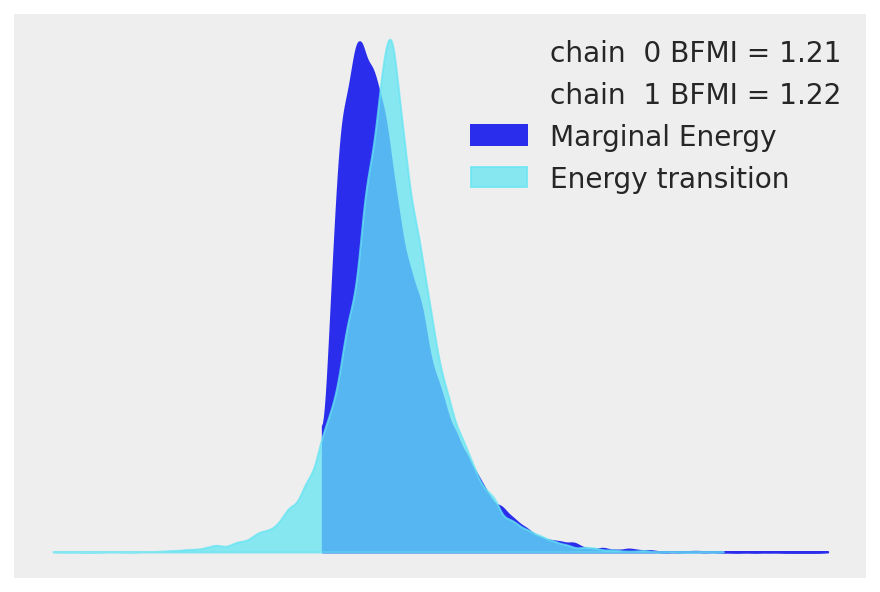

In [ ]:
az.plot_energy(trace);

* 参考資料
 * https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

# 課題
* HDIとは何かをしらべて、レポートしてください。



---



---



## 3.4 Hamiltonian Monte Carlo (HMC)
* ここでは直感的な説明をするにとどめる。
* Stanのマニュアルを参考にした。
 * https://mc-stan.org/docs/2_26/reference-manual/hamiltonian-monte-carlo.html
* その他の参考資料
 * https://ryokamoi.github.io/blog/tech/2018/12/09/hmc

### 3.4.1 補助変数
* 密度関数$p(\theta)$からのサンプリングを実現したいとする。
 * $p(\theta)$については、規格化定数は不明でも構わない。
* HMCでは、補助変数$\rho$を追加し、同時分布$p(\rho, \theta) = p(\rho|\theta)p(\theta)$からのサンプリングをおこなう。
* 多くの場合（Stanでも）、$\rho$の値が従う分布は、$\theta$に依存しない多変量正規分布だと仮定する。
$$\rho \sim \text{MultiNormal}(0, M)$$
 * $M$は対角成分しか持たないらしい（Stanのマニュアル参照）。

### 3.4.2 leapfrogアルゴリズム
* $V(\theta) \equiv - \ln p(\theta)$および$H(\rho, \theta) = - \ln p(\rho, \theta)$と定義する。
* leapfrogアルゴリズムでは、以下のように$\theta$を更新することで、サンプルのchainを作る。

1. $\rho$を$\text{MultiNormal}(0,M)$からdraw
2. 以下の一連の更新式を$L$回繰り返し実行する。
$$\begin{align}
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\notag \\
\theta & \leftarrow \theta + \epsilon M^{-1}\rho
\notag \\
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\end{align}$$
 * この結果、$\rho$は$\rho^*$へ、$\theta$は$\theta^*$へ、それぞれ更新されたとする。
3. この$\rho^*, \theta^*$を、確率$\min(1, \exp(H(\rho, \theta) - H(\rho^*, \theta^*)))$で、次のサンプルとして採用する。
 * 採用されなければ、元の$\rho,\theta$をそのまま次でも使う。



### 3.4.3 the no-U-turn sampling (NUTS) アルゴリズム
* leapfrogアルゴリズムで、$M$と$\epsilon$と$L$は、適切に調整すべきパラメータである。
* これらのパラメータを自動的に調整するアルゴリズムとしてHoffmanとGelmanにより提案されたのが、no-U-turn sampling (NUTS)アルゴリズムである。（終）

### 3.4.4 divergence
* leapfrogアルゴリズムは、$\frac{\partial V}{\partial \theta}$を使っている。
* 雰囲気を言うと、これは、本当なら$p(\theta)$の地形に沿って滑らかに動きたいところを、一階の微分を使って近似的に動いている。
* 近似であるため、本当ならそう動きたいという軌道から、外れてしまうこともある。
* この外れ方が非常に大きくなってしまうことを、divergenceと呼ぶ。
* divergenceが大きいと、得られたサンプルchainが所望の密度関数からのサンプルchainとみなせない。